<a href="https://colab.research.google.com/github/KoshKath/DataScience_Lab5/blob/main/DSHW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import yfinance as yf

def load_data(ticker, data_start, data_end):
    # загрузка данных с Yahoo Finance (Close уже скорректирован)
    data = yf.download(ticker, start=data_start, end=data_end, progress=False, auto_adjust=True)

    if data.empty:
        print("Данные не загружены.")
        return pd.DataFrame()
    # обработка MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [col[0].lower() for col in data.columns]
    else:
        data.columns = [c.lower() for c in data.columns]
    # приведение индекса в колонку date
    data.reset_index(inplace=True)
    if 'Date' in data.columns:
        data.rename(columns={'Date': 'date'}, inplace=True)
    # приведение числовых колонок к float
    numeric_cols = ['open', 'high', 'low', 'close', 'volume']
    for col in numeric_cols:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        else:
            data[col] = pd.NA

    # приведение даты в формат YYYY-MM-DD
    data['date'] = pd.to_datetime(data['date'], errors='coerce').dt.strftime('%Y-%m-%d')

    # отчёт о загруженных данных
    print(f"\nРазмер данных: {data.shape[0]} строк × {data.shape[1]} столбцов.")
    print(data.head())
    print(data.info())
    print(data.describe())

    return data

In [2]:
import sqlite3
import pandas as pd

def create_db(df, db_name="nvidia_stock.db", table_name="nvidia"):
    if df is None or df.empty:
        print("Нет данных для создания БД.")
        return None

    # сохранение нужных колонок
    for col in ['date','open','high','low','close','volume']:
        if col not in df.columns:
            df[col] = pd.NA
    df = df[['date','open','high','low','close','volume']]

    # приведение даты в формат YYYY-MM-DD
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

    try:
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()

        # создание таблицы, если нет
        cursor.execute(f"""
            CREATE TABLE IF NOT EXISTS {table_name} (
                date TEXT PRIMARY KEY,
                open REAL,
                high REAL,
                low REAL,
                close REAL,
                volume INTEGER
            )
        """)

        # получение существующих дат
        existing_dates = pd.read_sql_query(f"SELECT date FROM {table_name}", conn)

        # сохранение только новых строк
        df_to_insert = df[~df['date'].isin(existing_dates['date'])]

        if not df_to_insert.empty:
            df_to_insert.to_sql(table_name, conn, if_exists='append', index=False)
            print(f"В БД '{db_name}' добавлено {len(df_to_insert)} новых строк.")
        else:
            print("Все данные уже есть в БД. Новых записей нет.")

        return conn

    except Exception as e:
        print(f"Ошибка при создании БД: {e}")
        return None


In [3]:
import pandas as pd

def query_db(conn, query_name):
  # проверка соединения с БД
  if conn is None:
      raise ValueError("Соединение с БД не передано.")

  try:
      conn.execute("SELECT 1;") # возврат 1, для проверки соединения
  except sqlite3.ProgrammingError:
      raise ValueError("Соединение с БД закрыто или недействительно.")

  # словарь запросов
  queries = {
      "annual_volume": """
          SELECT
              STRFTIME('%Y', date) AS Year,
              SUM(volume) AS TotalVolume FROM nvidia
          WHERE date BETWEEN '2020-01-01' AND '2025-11-01'
          GROUP BY Year
          ORDER BY Year;
      """,
      "monthly_avg_close_2025": """
          SELECT
             STRFTIME('%Y-%m', date) AS Month,
             ROUND(AVG(close), 2) AS AvgClose
          FROM nvidia
          WHERE date BETWEEN '2025-01-01' AND '2025-11-30'
          GROUP BY Month
          ORDER BY Month;
      """,
      "monthly_volume_2025": """
          SELECT
             STRFTIME('%Y-%m', date) AS Month,
             SUM(volume) AS TotalVolume
          FROM nvidia
          WHERE date BETWEEN '2025-01-01' AND '2025-11-30'
          GROUP BY Month
          ORDER BY Month;
      """,
      "monthly_return_2025": """
          WITH monthly_close AS (
              SELECT
                STRFTIME('%Y-%m', date) AS Month,
                AVG(close) AS AvgClose
              FROM nvidia
              WHERE date BETWEEN '2025-01-01' AND '2025-11-30'
              GROUP BY Month
          ),
          monthly_with_lag AS (
              SELECT
                Month,
                AvgClose,
                LAG(AvgClose) OVER (ORDER BY Month) AS PrevAvgClose
              FROM monthly_close
          )
          SELECT
              Month,
              ROUND(((AvgClose - PrevAvgClose) / PrevAvgClose) * 100, 2) AS MonthlyReturnPct
          FROM monthly_with_lag
          WHERE PrevAvgClose IS NOT NULL
          ORDER BY Month;
      """
  }

  # проверка имени запроса
  if query_name not in queries:
      raise ValueError(f"Запрос '{query_name}' не найден. Доступные: {list(queries.keys())}")

  sql = queries[query_name]
  df = pd.read_sql_query(sql, conn)
  return df

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools

def train_arima_model(df, forecast_steps=10, plot=True):
    max_p=3
    max_d=1
    max_q=3

    # копия датафрейма и сортировка по дате
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values('date')
    df.set_index('date', inplace=True)

    # задание частоты временного ряда
    try:
        df = df.asfreq(pd.infer_freq(df.index))
    except:
        df = df.asfreq('B')

    # интерполяция пропусков
    series = df['close'].astype(float).interpolate()

    # проверка достаточности данных
    if len(series) < 10:
        raise ValueError("Не достаточно данных для построения модели ARIMA.")

    # разделение на train/test
    train_size = int(len(series) * 0.8)
    train, test = series[:train_size], series[train_size:]

    # автоподбор параметров по AIC
    best_aic = np.inf
    best_order = None
    best_model = None

    for p, d, q in itertools.product(range(max_p+1), range(max_d+1), range(max_q+1)):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, d, q)
                best_model = model_fit
        except Exception as e:
            continue

    print(f"Лучший порядок ARIMA: {best_order} с AIC = {best_aic:.2f}")

    # прогноз на тестовом периоде
    test_forecast = best_model.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, test_forecast))
    print(f"ARIMA RMSE на тестовом периоде: {rmse:.2f}")

    # прогноз на будущее
    last_date = df.index.max()
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=forecast_steps,
        freq=df.index.freq or 'B'
    )

    future_forecast = best_model.forecast(steps=forecast_steps)
    forecast_df = pd.DataFrame({'date': future_dates, 'forecast': future_forecast})

    # визуализация
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(train.index, train, label='Train', color='blue')
        plt.plot(test.index, test, label='Test (real)', color='orange')
        plt.plot(test.index, test_forecast, label='Forecast (test)', color='red', linestyle='--')
        plt.plot(future_dates, future_forecast, label=f'Forecast ({forecast_steps} дней вперед)', color='green', linestyle='--')
        plt.axvline(x=test.index[-1], color='gray', linestyle=':', label='Точка начала прогноза')
        plt.title(f"ARIMA прогноз цены NVDA (+{forecast_steps} рабочих дней)")
        plt.xlabel("Дата")
        plt.ylabel("Цена закрытия")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    return forecast_df, rmse

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def train_lstm_model(df, forecast_steps=10, plot=True, look_back=10, epochs=50, batch_size=16):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values('date')
    df.set_index('date', inplace=True)

    # интерполяция пропусков
    series = df['close'].astype(float).interpolate().values.reshape(-1,1)

    # масштабирование
    scaler = MinMaxScaler(feature_range=(0,1))
    series_scaled = scaler.fit_transform(series)

    # разделение на обучающий и тестовый периоды
    train_size = int(len(series_scaled) * 0.8)
    train, test = series_scaled[:train_size], series_scaled[train_size:]

    # создание выборок для LSTM
    def create_dataset(dataset, look_back):
        X, y = [], []
        for i in range(len(dataset)-look_back):
            X.append(dataset[i:(i+look_back),0])
            y.append(dataset[i+look_back,0])
        return np.array(X), np.array(y)

    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(np.vstack((train[-look_back:], test)), look_back)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # создание модели LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # обучение модели LSTM
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # прогноз на тестовой выборке
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))

    # синхронизация размеров для RMSE
    min_len = min(len(y_pred), len(y_test_real))
    y_pred = y_pred[:min_len]
    y_test_real = y_test_real[:min_len]

    rmse = np.sqrt(np.mean((y_test_real - y_pred)**2))
    print(f"LSTM RMSE на тестовой выборке: {rmse:.2f}")

    # прогноз на будущее
    last_seq = series_scaled[-look_back:]
    future_forecast = []
    seq = last_seq.copy()
    for _ in range(forecast_steps):
        x_input = seq.reshape((1, look_back, 1))
        yhat = model.predict(x_input)[0,0]
        future_forecast.append(yhat)
        seq = np.append(seq[1:], yhat).reshape(-1,1)
    future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1,1))

    # даты для будущего прогноза
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
    forecast_df = pd.DataFrame({'date': future_dates, 'forecast': future_forecast.flatten()})

    # визуализация результата
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(df.index[:train_size], scaler.inverse_transform(train), label='Train', color='blue')
        plt.plot(df.index[train_size:train_size+len(y_test_real)], y_test_real, label='Test (real)', color='orange')
        plt.plot(df.index[train_size:train_size+len(y_pred)], y_pred, label='Forecast (test)', color='red', linestyle='--')
        plt.plot(future_dates, future_forecast, label=f'Forecast ({forecast_steps} дней вперед)', color='green', linestyle='--')
        plt.axvline(x=df.index[-1], color='gray', linestyle=':', label='Точка начала прогноза')
        plt.title(f"LSTM прогноз цены (+{forecast_steps} рабочих дней)")
        plt.xlabel("Дата")
        plt.ylabel("Цена закрытия")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    return forecast_df, rmse



Размер данных: 1467 строк × 6 столбцов.
         date     close      high       low      open     volume
0  2020-01-02  5.971410  5.971410  5.892010  5.942537  237536000
1  2020-01-03  5.875831  5.919638  5.826797  5.851688  205384000
2  2020-01-06  5.900472  5.905699  5.756358  5.782493  262636000
3  2020-01-07  5.971908  6.017706  5.883797  5.928848  314856000
4  2020-01-08  5.983109  6.024426  5.927603  5.967677  277108000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467 entries, 0 to 1466
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1467 non-null   object 
 1   close   1467 non-null   float64
 2   high    1467 non-null   float64
 3   low     1467 non-null   float64
 4   open    1467 non-null   float64
 5   volume  1467 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 68.9+ KB
None
             close         high          low         open        volume
count  1467.000000  1467.00

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/sta

Лучший порядок ARIMA: (3, 1, 2) с AIC = 5336.05
ARIMA RMSE на тестовом периоде: 36.73


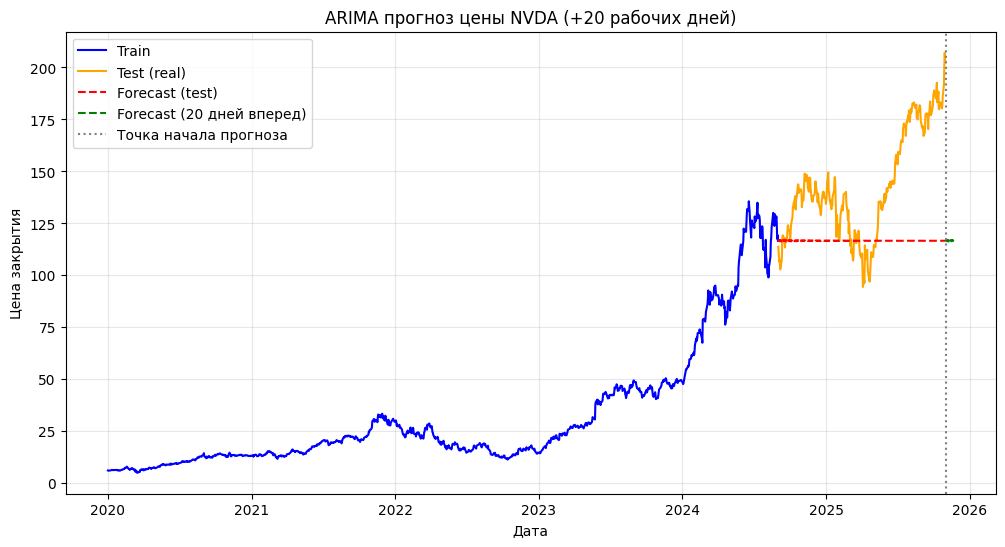


 Прогноз ARIMA вперед:
                 date    forecast
2024-09-01 2025-11-01  116.236364
2024-09-02 2025-11-02  116.854424
2024-09-03 2025-11-03  116.416447
2024-09-04 2025-11-04  116.363335
2024-09-05 2025-11-05  116.860783
2024-09-06 2025-11-06  116.279466
2024-09-07 2025-11-07  116.531702
2024-09-08 2025-11-08  116.780760
2024-09-09 2025-11-09  116.216203
2024-09-10 2025-11-10  116.690752
2024-09-11 2025-11-11  116.640295
2024-09-12 2025-11-12  116.239042
2024-09-13 2025-11-13  116.799459
2024-09-14 2025-11-14  116.479474
2024-09-15 2025-11-15  116.337183
2024-09-16 2025-11-16  116.832248
2024-09-17 2025-11-17  116.341452
2024-09-18 2025-11-18  116.480764
2024-09-19 2025-11-19  116.784815
2024-09-20 2025-11-20  116.261006


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM RMSE на тестовой выборке: 5.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


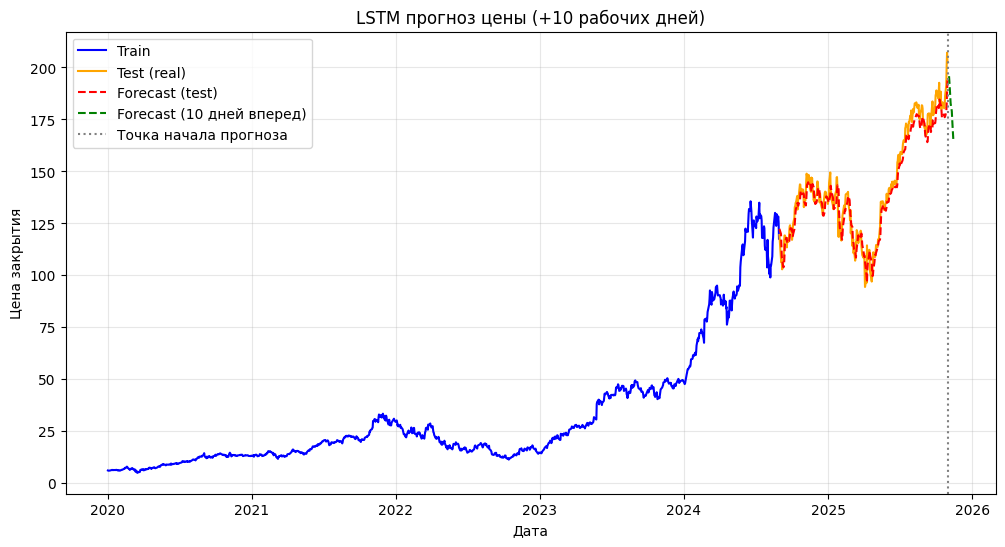


 Прогноз LSTM вперед:
        date    forecast
0 2025-11-03  195.745499
1 2025-11-04  192.882690
2 2025-11-05  189.609360
3 2025-11-06  186.265152
4 2025-11-07  182.682602
5 2025-11-10  178.899200
6 2025-11-11  175.047562
7 2025-11-12  171.439056
8 2025-11-13  167.995667
9 2025-11-14  164.749847


In [6]:
import yfinance as yf
import pandas as pd

# загрузка данных с Yahoo Finance
ticker = "NVDA"
data_start = "2020-01-01"
data_end = "2025-11-01"
df_nvda = load_data(ticker, data_start, data_end)
# проверка загрузки данных
if df_nvda.empty:
    raise RuntimeError("Данные для NVDA не загружены. Создание БД невозможно.")
# создание БД и соединения
conn = create_db(df_nvda)

# проверка соединения перед запросами
if conn is None:
    raise RuntimeError("Не удалось создать соединение с БД.")

annual_volume_query = query_db(conn, "annual_volume")
print("\n Объем торгов по годам:")
print(annual_volume_query)

avg_close_query = query_db(conn, "monthly_avg_close_2025")
print("\n Средняя цена закрытия акции в 2025:")
print(avg_close_query)

volume_2025_query = query_db(conn, "monthly_volume_2025")
print("\n Объем торгов в 2025 (активность рынка):")
print(volume_2025_query)

avg_volume_2025_query = query_db(conn, "monthly_return_2025")
print("\n Средняя месячная доходность в 2025 (изменение закрытия от месяца к месяцу):")
print(avg_volume_2025_query)

# закрытие соединения с БД
conn.close()

# создание модели ARIMA
forecast_df_ar, rmse_arima = train_arima_model(df_nvda, forecast_steps=20)
print("\n Прогноз ARIMA вперед:")
print(forecast_df_ar)

# создание модели LSTM
forecast_df_lstm, rmse_lstm = train_lstm_model(df_nvda, forecast_steps=10, plot=True, look_back=10, epochs=50, batch_size=16)
print("\n Прогноз LSTM вперед:")
print(forecast_df_lstm)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools

def train_arima_model(df, forecast_steps=10, plot=True):
    max_p=3
    max_d=1
    max_q=3
    # подготовка данных для модели
    df = df.copy()
    # преобразование date в datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values('date')
    df.set_index('date', inplace=True)

    # интерпорляция пропусков close (если будут)
    series = df['close'].astype(float).interpolate()

    # проверка достаточности данных
    if len(series) < 10:
        raise ValueError("Не достаточно данных для построения модели ARIMA.")

    # разделение данных на обучающий и тестовый периоды 80/20
    train_size = int(len(series) * 0.8)
    train, test = series[:train_size], series[train_size:]

    # автоподбор параметров ARIMA по AIC
    best_aic = np.inf
    best_order = None
    best_model = None

    for p, d, q in itertools.product(range(max_p+1), range(max_d+1), range(max_q+1)):
        try:
            # создание модели ARIMA
            model = ARIMA(train, order=(p,d,q))
            # обучение модели ARIMA
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p,d,q)
                best_model = model_fit
        except:
            continue

    print(f"Лучший порядок ARIMA: {best_order} с AIC = {best_aic:.2f}")

    # прогноз на тестовом периоде
    test_forecast = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, test_forecast))
    print(f"ARIMA RMSE на тестовом периоде: {rmse:.2f}")

    # прогноз на будущее
    last_date = df.index.max()
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=forecast_steps,
        freq='B'  # рабочие дни
    )

    future_forecast = model_fit.forecast(steps=forecast_steps)
    forecast_df = pd.DataFrame({'date': future_dates, 'forecast': future_forecast})

    # визуализация результата
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(train.index, train, label='Train', color='blue')
        plt.plot(test.index, test, label='Test (real)', color='orange')
        plt.plot(test.index, test_forecast, label='Forecast (test)', color='red', linestyle='--')
        plt.plot(future_dates, future_forecast, label=f'Forecast ({forecast_steps} дней вперед)', color='green', linestyle='--')
        plt.axvline(x=test.index[-1], color='gray', linestyle=':', label='Точка начала прогноза')
        plt.title(f"ARIMA прогноз цены NVDA (+{forecast_steps} рабочих дней)")
        plt.xlabel("Дата")
        plt.ylabel("Цена закрытия")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    return forecast_df, rmse